In [28]:
!pip install torch torchtext datasets nltk matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import math
import time
import os
import requests
import zipfile
import io

In [15]:
# random seed values
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [16]:
# Load and Preprocess the Dataset
def load_shakespeare_dataset():
    dataset = load_dataset("tiny_shakespeare")
    return dataset

def preprocess_text(text):

    if isinstance(text, list):
        text = ' '.join(text)
    return text.lower().split()

def build_vocab(tokenized_text):
    word_counts = {}
    for word in tokenized_text:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    # Sort by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Create word to index mapping
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in sorted_words:
        word_to_idx[word] = len(word_to_idx)
    
    # word mapping
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    return word_to_idx, idx_to_word

In [18]:
def create_sequences(tokenized_text, word_to_idx, seq_length=5):
    sequences = []
    targets = []
    
    for i in range(len(tokenized_text) - seq_length):
        seq = tokenized_text[i:i+seq_length]
        target = tokenized_text[i+seq_length]
        
        # Convert words to indices
        seq_indices = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in seq]
        target_idx = word_to_idx.get(target, word_to_idx['<UNK>'])
        
        sequences.append(seq_indices)
        targets.append(target_idx)
    
    return np.array(sequences), np.array(targets)


class ShakespeareDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.LongTensor(sequences)
        self.targets = torch.LongTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [19]:
# Vanilla RNN Model
class VanillaRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VanillaRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Parameters for the input projection
        self.weight_ih = nn.Parameter(torch.Tensor(hidden_size, input_size))
        
        # Parameters for the hidden state projection
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        
        # Bias terms
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size))
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_ih)
        nn.init.xavier_uniform_(self.weight_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
    
    def forward(self, input, hidden):
        h_next = torch.tanh(
            torch.mm(input, self.weight_ih.t()) + self.bias_ih +
            torch.mm(hidden, self.weight_hh.t()) + self.bias_hh
        )
        
        return h_next

#RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, use_pretrained=False, pretrained_vectors=None):
        super(VanillaRNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Embedding layer
        if use_pretrained and pretrained_vectors is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_vectors, padding_idx=0)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # RNN cell
        self.rnn_cell = VanillaRNNCell(embedding_size, hidden_size)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        batch_size, seq_length = x.size()
        
        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        # Convert input to embeddings
        embedded = self.embedding(x) 
        
        
        outputs = []
        for t in range(seq_length):
            # Get the embedding at time step t
            input_t = embedded[:, t, :]
            
            # Pass through the RNN cell
            hidden = self.rnn_cell(input_t, hidden)  
            
            # Store the output
            outputs.append(hidden)
        
        # Concatenate outputs
        outputs = torch.stack(outputs, dim=1)  
        
        # Pass through the output layer
        logits = self.fc(outputs[:, -1, :])  
        
        return logits, hidden
    
    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.hidden_size, device=device)


In [20]:
def train_model(model, train_loader, val_loader, epochs, lr, device, clip=5.0):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    
    # Start training
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        epoch_loss = 0
        
        for batch_idx, (sequences, targets) in enumerate(train_loader):
            sequences, targets = sequences.to(device), targets.to(device)
            
            # Initialize hidden state
            hidden = model.init_hidden(sequences.size(0), device)
            
            # Forward pass
            optimizer.zero_grad()
            output, hidden = model(sequences, hidden)
            
            # Calculate loss
            loss = criterion(output, targets)
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        # average loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                hidden = model.init_hidden(sequences.size(0), device)
                output, hidden = model(sequences, hidden)
                loss = criterion(output, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        elapsed = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs} completed in {elapsed:.2f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses

In [22]:
# Text Generation
def generate_text(model, seed_text, word_to_idx, idx_to_word, seq_length, num_words=10, device='cpu'):
    model.eval()
    
    words = seed_text.lower().split()
    
    current_sequence = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words[-seq_length:]]
    
    # Generate words
    generated_words = []
    
    with torch.no_grad():
        for _ in range(num_words):
            # Prepare input
            x = torch.LongTensor(current_sequence).unsqueeze(0).to(device)  # (1, seq_length)
            
            # Initialize hidden state
            hidden = model.init_hidden(1, device)
            
            # Get predictions
            output, hidden = model(x, hidden)
            
            probs = torch.softmax(output, dim=1)
            predicted_idx = torch.multinomial(probs, 1).item()
            
            # Add to generated words
            predicted_word = idx_to_word[predicted_idx]
            generated_words.append(predicted_word)
            
            # Update sequence
            current_sequence = current_sequence[1:] + [predicted_idx]
    
    #  generated text
    result = seed_text + " " + " ".join(generated_words)
    return result

In [23]:
#Evaluation 
def compute_perplexity(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_words = 0
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            hidden = model.init_hidden(sequences.size(0), device)
            output, hidden = model(sequences, hidden)
            loss = criterion(output, targets)
            total_loss += loss.item() * len(targets)
            total_words += len(targets)
    
    
    avg_loss = total_loss / total_words
    perplexity = math.exp(avg_loss)
    
    return perplexity

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            hidden = model.init_hidden(sequences.size(0), device)
            output, hidden = model(sequences, hidden)
            
            # Get predictions
            _, predicted = torch.max(output, 1)
            
            # Update counts
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Store for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = correct / total
    return accuracy, all_preds, all_targets

In [32]:
def plot_confusion_matrix(all_preds, all_targets, idx_to_word, top_n=10, filename=None):
    # Get word counts
    word_counts = {}
    for idx in all_targets:
        word = idx_to_word[idx]
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    # Get top N words
    word_to_idx = {word: idx for idx, word in idx_to_word.items()}
    top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_word_indices = [word_to_idx[word] for word, _ in top_words]
    
    word_to_idx = {word: idx for idx, word in idx_to_word.items()}
    
    filtered_preds = []
    filtered_targets = []
    for i in range(len(all_preds)):
        if all_targets[i] in top_word_indices:
            filtered_preds.append(all_preds[i])
            filtered_targets.append(all_targets[i])
    
    cm = confusion_matrix(filtered_targets, filtered_preds, labels=top_word_indices)
    
    
    display_labels = [idx_to_word[idx] for idx in top_word_indices]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix for Top Words")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        print(f"Saved confusion matrix to {filename}")
    
    plt.show()

def plot_loss_curves(train_losses, val_losses, filename=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    plt.tight_layout()
    
    # Save the figure if filename is provided
    if filename:
        plt.savefig(filename)
        print(f"Saved loss curves to {filename}")
    
    # Display the plot
    plt.show()

In [25]:
# Load Pretrained Embeddings
def load_glove_embeddings(word_to_idx, embedding_dim=50): # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    
    glove_path = '/kaggle/input/glove6/glove.6B.50d.txt'
    
    print(f"Loading GloVe embeddings from {glove_path}...")
    word_to_vector = {}
    
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_vector[word] = vector
    
    print(f"Loaded {len(word_to_vector)} word vectors.")
    
    # Create embedding matrix
    embedding_matrix = torch.zeros((len(word_to_idx), embedding_dim))
  
    found_words = 0
    for word, idx in word_to_idx.items():
        if word in word_to_vector:
            embedding_matrix[idx] = torch.tensor(word_to_vector[word])
            found_words += 1
        else:
            # Random initialization for unknown words
            embedding_matrix[idx] = torch.randn(embedding_dim)
    
    print(f"Found embeddings for {found_words}/{len(word_to_idx)} words.")
    return embedding_matrix
    return embedding_matrix


Using device: cuda
Loading dataset...
Preprocessing text...
Building vocabulary...
Vocabulary size: 21949
Creating sequences...
Splitting into train and test sets...
Creating datasets and dataloaders...
Creating and training model with random embeddings...
Epoch: 1/10, Batch: 100/2282, Loss: 7.7687
Epoch: 1/10, Batch: 200/2282, Loss: 7.8550
Epoch: 1/10, Batch: 300/2282, Loss: 7.2881
Epoch: 1/10, Batch: 400/2282, Loss: 7.3013
Epoch: 1/10, Batch: 500/2282, Loss: 6.7452
Epoch: 1/10, Batch: 600/2282, Loss: 7.6717
Epoch: 1/10, Batch: 700/2282, Loss: 7.6709
Epoch: 1/10, Batch: 800/2282, Loss: 7.4567
Epoch: 1/10, Batch: 900/2282, Loss: 7.9963
Epoch: 1/10, Batch: 1000/2282, Loss: 7.5778
Epoch: 1/10, Batch: 1100/2282, Loss: 7.3899
Epoch: 1/10, Batch: 1200/2282, Loss: 7.2147
Epoch: 1/10, Batch: 1300/2282, Loss: 7.3782
Epoch: 1/10, Batch: 1400/2282, Loss: 7.4314
Epoch: 1/10, Batch: 1500/2282, Loss: 7.6772
Epoch: 1/10, Batch: 1600/2282, Loss: 7.8882
Epoch: 1/10, Batch: 1700/2282, Loss: 7.4076
Epoc

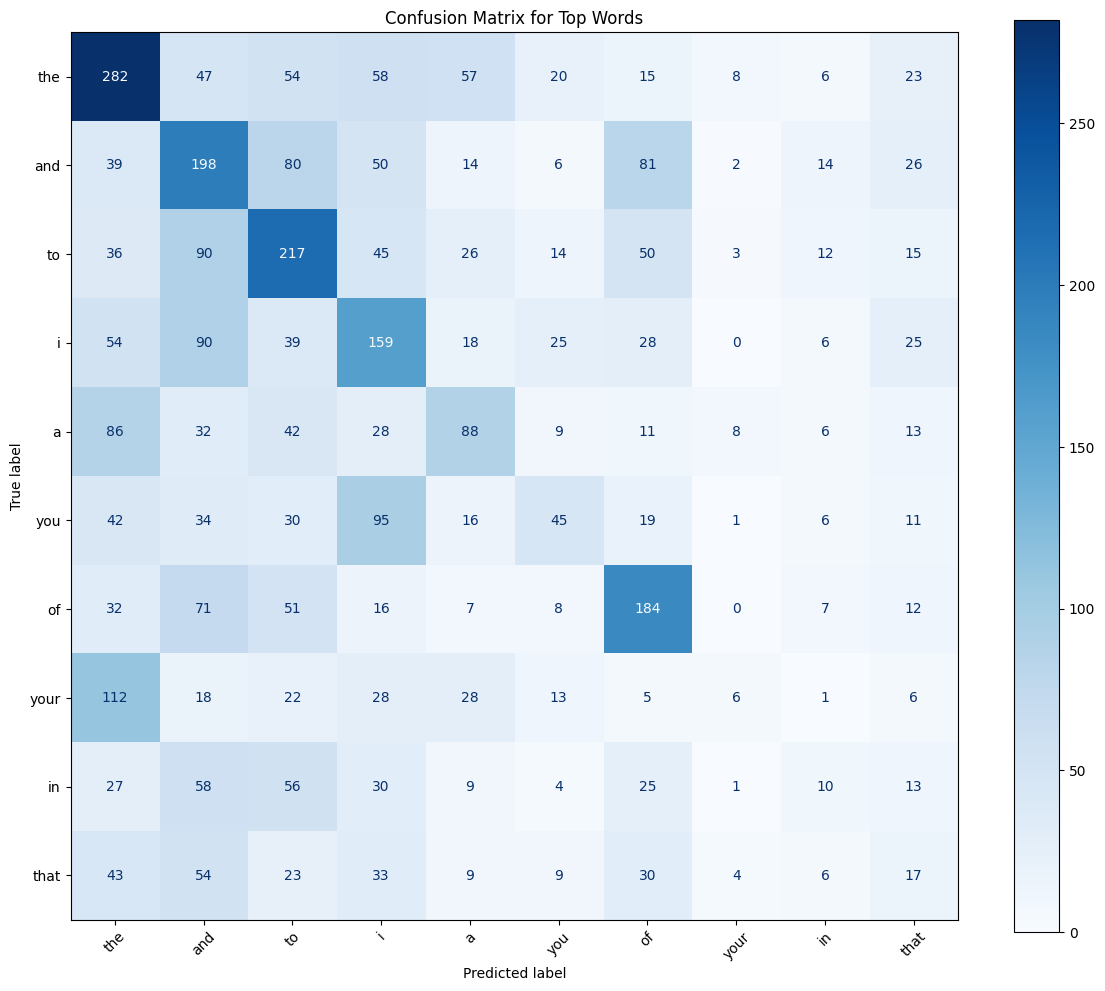

Saved loss curves to loss_curves_random.png


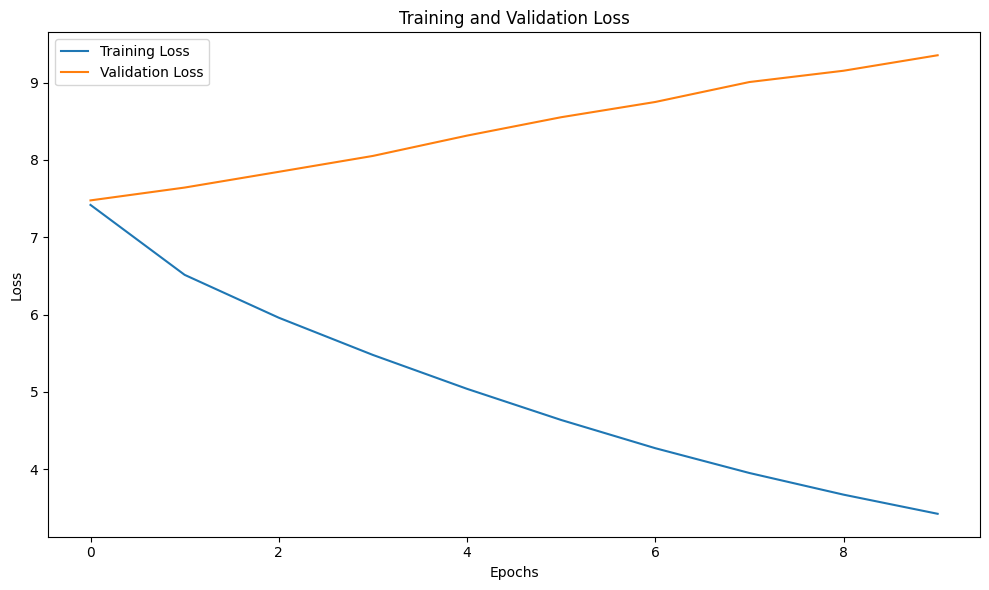

Loading pretrained GloVe embeddings
Loading GloVe embeddings from /kaggle/input/glove6/glove.6B.50d.txt...
Loaded 400000 word vectors.
Found embeddings for 7808/21949 words.
Creating and training model with pretrained embeddings
Epoch: 1/10, Batch: 100/2282, Loss: 7.6010
Epoch: 1/10, Batch: 200/2282, Loss: 7.8996
Epoch: 1/10, Batch: 300/2282, Loss: 7.6938
Epoch: 1/10, Batch: 400/2282, Loss: 7.4548
Epoch: 1/10, Batch: 500/2282, Loss: 7.3317
Epoch: 1/10, Batch: 600/2282, Loss: 6.8487
Epoch: 1/10, Batch: 700/2282, Loss: 6.4622
Epoch: 1/10, Batch: 800/2282, Loss: 7.2714
Epoch: 1/10, Batch: 900/2282, Loss: 7.2518
Epoch: 1/10, Batch: 1000/2282, Loss: 7.5342
Epoch: 1/10, Batch: 1100/2282, Loss: 8.0295
Epoch: 1/10, Batch: 1200/2282, Loss: 6.8526
Epoch: 1/10, Batch: 1300/2282, Loss: 6.6577
Epoch: 1/10, Batch: 1400/2282, Loss: 7.4504
Epoch: 1/10, Batch: 1500/2282, Loss: 7.5438
Epoch: 1/10, Batch: 1600/2282, Loss: 5.9095
Epoch: 1/10, Batch: 1700/2282, Loss: 7.7088
Epoch: 1/10, Batch: 1800/2282, L

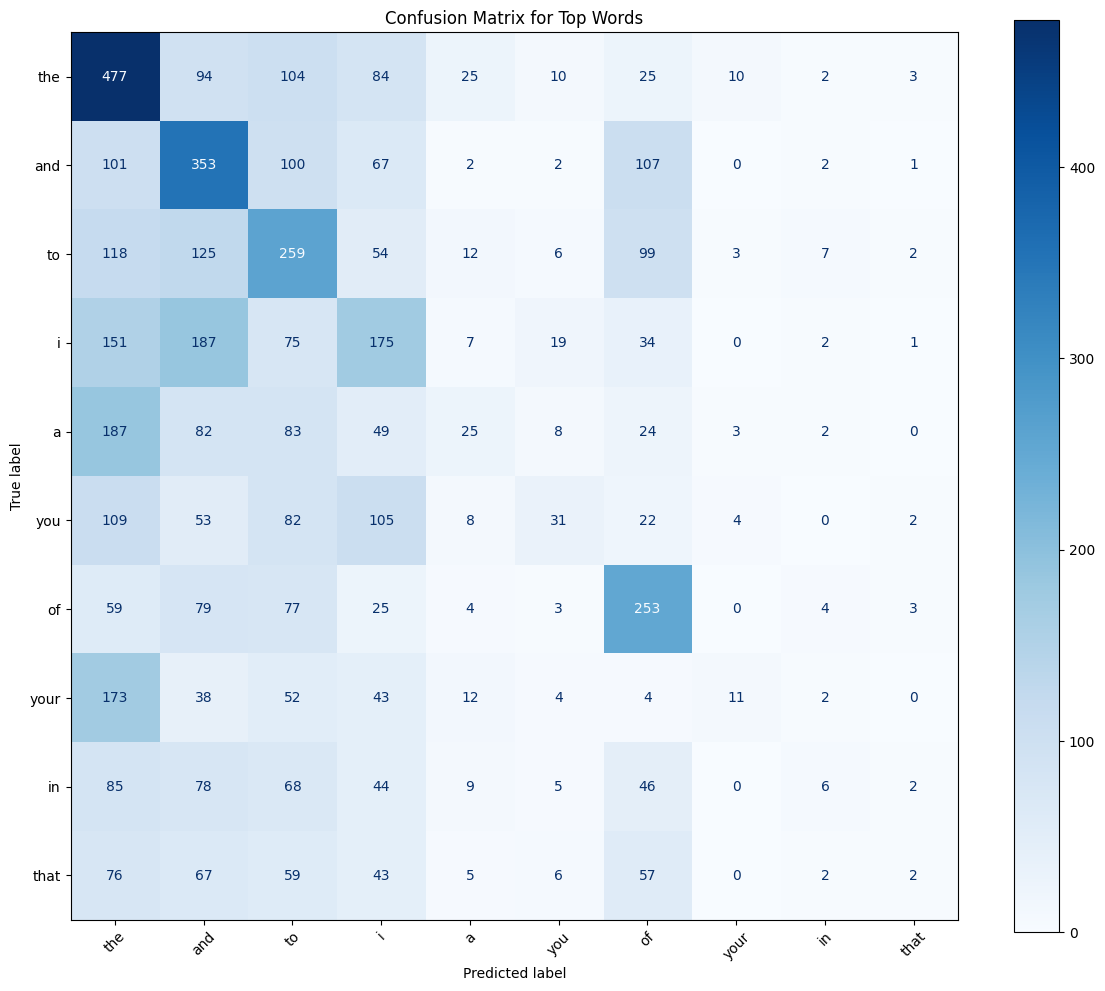

Saved loss curves to loss_curves_pretrained.png


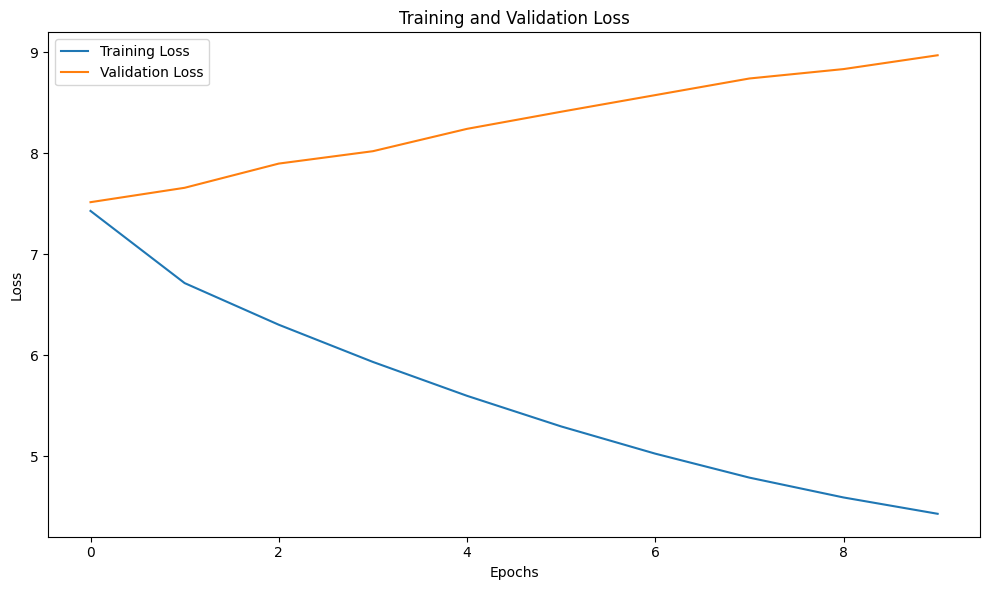


Comparison of Word-Level Accuracy and Perplexity for Different Embeddings:
--------------------------------------------------------------------------------
Embedding Type       | Word-Level Accuracy  | Perplexity          
--------------------------------------------------------------------------------
Random Embeddings    | 0.0536               | 11567.10            
Pretrained Embeddings | 0.0604               | 7893.16             
--------------------------------------------------------------------------------


In [33]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load dataset
    print("Loading dataset...")
    dataset = load_shakespeare_dataset()
    
    # Preprocess text
    print("Preprocessing text...")
 
    if 'train' in dataset and 'text' in dataset['train']:
        text = dataset['train']['text']
    elif 'train' in dataset:
       
        first_item = dataset['train'][0]
        if isinstance(first_item, dict) and 'text' in first_item:
           
            text = ' '.join([item['text'] for item in dataset['train']])
        else:
            
            text = str(dataset['train'])
    else:
        raise ValueError("Could not find text data in the dataset")
        
    tokenized_text = preprocess_text(text)
    
    # Build vocabulary
    print("Building vocabulary")
    word_to_idx, idx_to_word = build_vocab(tokenized_text)
    vocab_size = len(word_to_idx)
    print(f"Vocabulary size: {vocab_size}")
    
    # Create sequences
    print("Creating sequences")
    seq_length = 5
    sequences, targets = create_sequences(tokenized_text, word_to_idx, seq_length)
    
    # Split into train and test
    print("Splitting into train and test sets...")
    split_idx = int(0.8 * len(sequences))
    train_sequences, test_sequences = sequences[:split_idx], sequences[split_idx:]
    train_targets, test_targets = targets[:split_idx], targets[split_idx:]
    
    
   
    train_dataset = ShakespeareDataset(train_sequences, train_targets)
    test_dataset = ShakespeareDataset(test_sequences, test_targets)
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model hyperparameters
    embedding_size = 50  
    hidden_size = 128
    
    print("Creating and training model with random embeddings...")
    model_random = VanillaRNN(vocab_size, embedding_size, hidden_size)
    model_random = model_random.to(device)
    
    # Train the model
    epochs = 10
    learning_rate = 0.001
    
    train_losses_random, val_losses_random = train_model(
        model_random, train_loader, test_loader, epochs, learning_rate, device
    )
    
    # Save the model
    torch.save(model_random.state_dict(), 'rnn_model_random.pt')
    
    # Generate text
    seed_text = "to be or not to"
    generated_text_random = generate_text(
        model_random, seed_text, word_to_idx, idx_to_word, seq_length, num_words=10, device=device
    )
    print(f"Generated text (Random Embeddings): {generated_text_random}")
    
    # Evaluate model with random embeddings
    criterion = nn.CrossEntropyLoss()
    perplexity_random = compute_perplexity(model_random, test_loader, criterion, device)
    accuracy_random, all_preds_random, all_targets_random = compute_accuracy(model_random, test_loader, device)
    
    print(f"Model with Random Embeddings - Perplexity: {perplexity_random:.2f}, Accuracy: {accuracy_random:.4f}")
    
    #  confusion matrix for random embeddings
    plot_confusion_matrix(all_preds_random, all_targets_random, idx_to_word, filename='confusion_matrix_random.png')
    
    
    #  loss curves for random embeddings
    plot_loss_curves(train_losses_random, val_losses_random, filename='loss_curves_random.png')
    

    print("Loading pretrained GloVe embeddings")
    pretrained_vectors = load_glove_embeddings(word_to_idx, embedding_size)
    
    # Create and train the model with pretrained embeddings
    print("Creating and training model with pretrained embeddings")
    model_pretrained = VanillaRNN(vocab_size, embedding_size, hidden_size, use_pretrained=True, pretrained_vectors=pretrained_vectors)
    model_pretrained = model_pretrained.to(device)
    
    # Train the model
    train_losses_pretrained, val_losses_pretrained = train_model(
        model_pretrained, train_loader, test_loader, epochs, learning_rate, device
    )
    
    # Save the model
    torch.save(model_pretrained.state_dict(), 'rnn_model_pretrained.pt')
    
    # Generate text
    generated_text_pretrained = generate_text(
        model_pretrained, seed_text, word_to_idx, idx_to_word, seq_length, num_words=10, device=device
    )
    print(f"Generated text (Pretrained Embeddings): {generated_text_pretrained}")
    
    # Evaluate model with pretrained embeddings
    perplexity_pretrained = compute_perplexity(model_pretrained, test_loader, criterion, device)
    accuracy_pretrained, all_preds_pretrained, all_targets_pretrained = compute_accuracy(model_pretrained, test_loader, device)
    
    print(f"Model with Pretrained Embeddings - Perplexity: {perplexity_pretrained:.2f}, Accuracy: {accuracy_pretrained:.4f}")
    
    #  confusion matrix for pretrained embeddings
    plot_confusion_matrix(all_preds_pretrained, all_targets_pretrained, idx_to_word, filename='confusion_matrix_pretrained.png')
    
    
    #  loss curves for pretrained embeddings
    plot_loss_curves(train_losses_pretrained, val_losses_pretrained, filename='loss_curves_pretrained.png')
    
    # Create comparison table
    print("\nComparison of Word-Level Accuracy and Perplexity for Different Embeddings:")
    print("-" * 80)
    print(f"{'Embedding Type':<20} | {'Word-Level Accuracy':<20} | {'Perplexity':<20}")
    print("-" * 80)
    print(f"{'Random Embeddings':<20} | {accuracy_random:<20.4f} | {perplexity_random:<20.2f}")
    print(f"{'Pretrained Embeddings':<20} | {accuracy_pretrained:<20.4f} | {perplexity_pretrained:<20.2f}")
    print("-" * 80)

if __name__ == "__main__":
    main()